In [ ]:
from xander.engine importturn.movement_directions() dice
from xander.engine.damage import Damage, DamageCause, Fire, Cold

dice.set_seed(0)
damage = Fire("2d6", cause=DamageCause.UNKNOWN)
damage += Cold("12d6", cause=DamageCause.UNKNOWN)
damage

In [ ]:
sgn = lambda x: -1 if x < 0 else 1
def omni_distance(x: int, y: int) -> tuple[int, int, int]:
    c = min(abs(x), abs(y))
    a = sgn(x) * (x - sgn(x) * c)
    b = sgn(y) * (y - sgn(y) * c)

    return (a, b, c)

In [4]:
import typing
from xander.engine.combat.action.attack import Attack
from xander.engine.combat.turn import Turn
from xander.engine.legality import Legality
from xander.engine.combat import Combatant

from random import randrange

class RandomAgent:
    """
    An agent that randomly selects either a move or attack.
    This should only act legally.
    """
    combatant: Combatant
    attacks: list[Attack]

    def __init__(self, combatant: Combatant):
        self.combatant = combatant
        self.attacks = [action.as_attack() for action in combatant.stats.actions]

    def hook(self, turn: Turn) -> "Legality[typing.Any]":
        # This shouldn't really occur, but there's a bug somewhere.
        if self.combatant.stats.dead:
            return turn.end()
        

        # TODO: Add attacking.
        movement_directions: list[tuple[float, float, float]] = [] if (l := turn.movement_directions()).is_illegal() else l.inner()
        l_attack = turn.attack_directions(self.attacks[0], lambda x: not x.stats.dead)

        attack_directions: list[tuple[Attack, tuple[float, float, float]]] = []
        if l_attack.is_legal():
            attack_directions = l_attack.inner()
        
        opt = randrange(len(movement_directions) + len(attack_directions) + 1)

        l: Legality[typing.Any]

        if opt < len(movement_directions):
            l = turn.move(movement_directions[opt])
        elif opt < len(movement_directions) + len(attack_directions):
            dir = attack_directions[opt - len(movement_directions)]
            l = turn.attack(self.attacks[0], dir)
        else:
            l = turn.end()

        if l.is_illegal():
            return turn.end()

        return l

class AlwaysSkipAgent:
    combatant: Combatant
    def __init__(self, combatant: Combatant):
        self.combatant = combatant

    def hook(self, turn: Turn) -> "Legality[None]":
        return turn.end()

class UserAgent:
    combatant: Combatant
    attacks: list[Attack]

    def __init__(self, combatant: Combatant):
        self.combatant = combatant
        self.attacks = [action.as_attack() for action in combatant.stats.actions]

    def hook(self, turn: Turn) -> "Legality[typing.Any]":
        to_do = input(f"{self.combatant.name}: _A_ttack / _M_ove / _E_nd: ")

        match to_do:
            case "M":
                x, y, z = map(float, input("Delta: ").split(", "))
                return turn.move((x, y, z))

            case "A":
                x, y, z = map(float, input("Absolute Target: ").split(", "))

                return turn.attack(self.attacks[0], (x, y, z))
                    
            case "E":
                return turn.end()
            
            case "":
                raise Exception()

Hit { attacker: (Weak), attack: Melee(MeleeAttackAction { name: "Bite", description: "", to_hit: Constant(0), range: Reach, target: Single, damage: [(Constant(1), DamageTypeMeta { name: "PIERCING", description: "Puncturing and impaling attacks, including spears and monsters' bites, deal piercing damage.", index: 8 })] }), target: (Weak), to_hit: AttackRoll(Add(Roll([19]), Modifier(0))), damage: Damage([DamagePart { damage_type: DamageTypeMeta { name: "PIERCING", description: "Puncturing and impaling attacks, including spears and monsters' bites, deal piercing damage.", index: 8 }, amount: Modifier(1), cause: DamageCause { actor: Entity((Weak)), source: DamageSource }, handling: DamageHandling { resistance: false, vulnerability: false, immunity: false } }]) }

Combat(6 members)

Arena
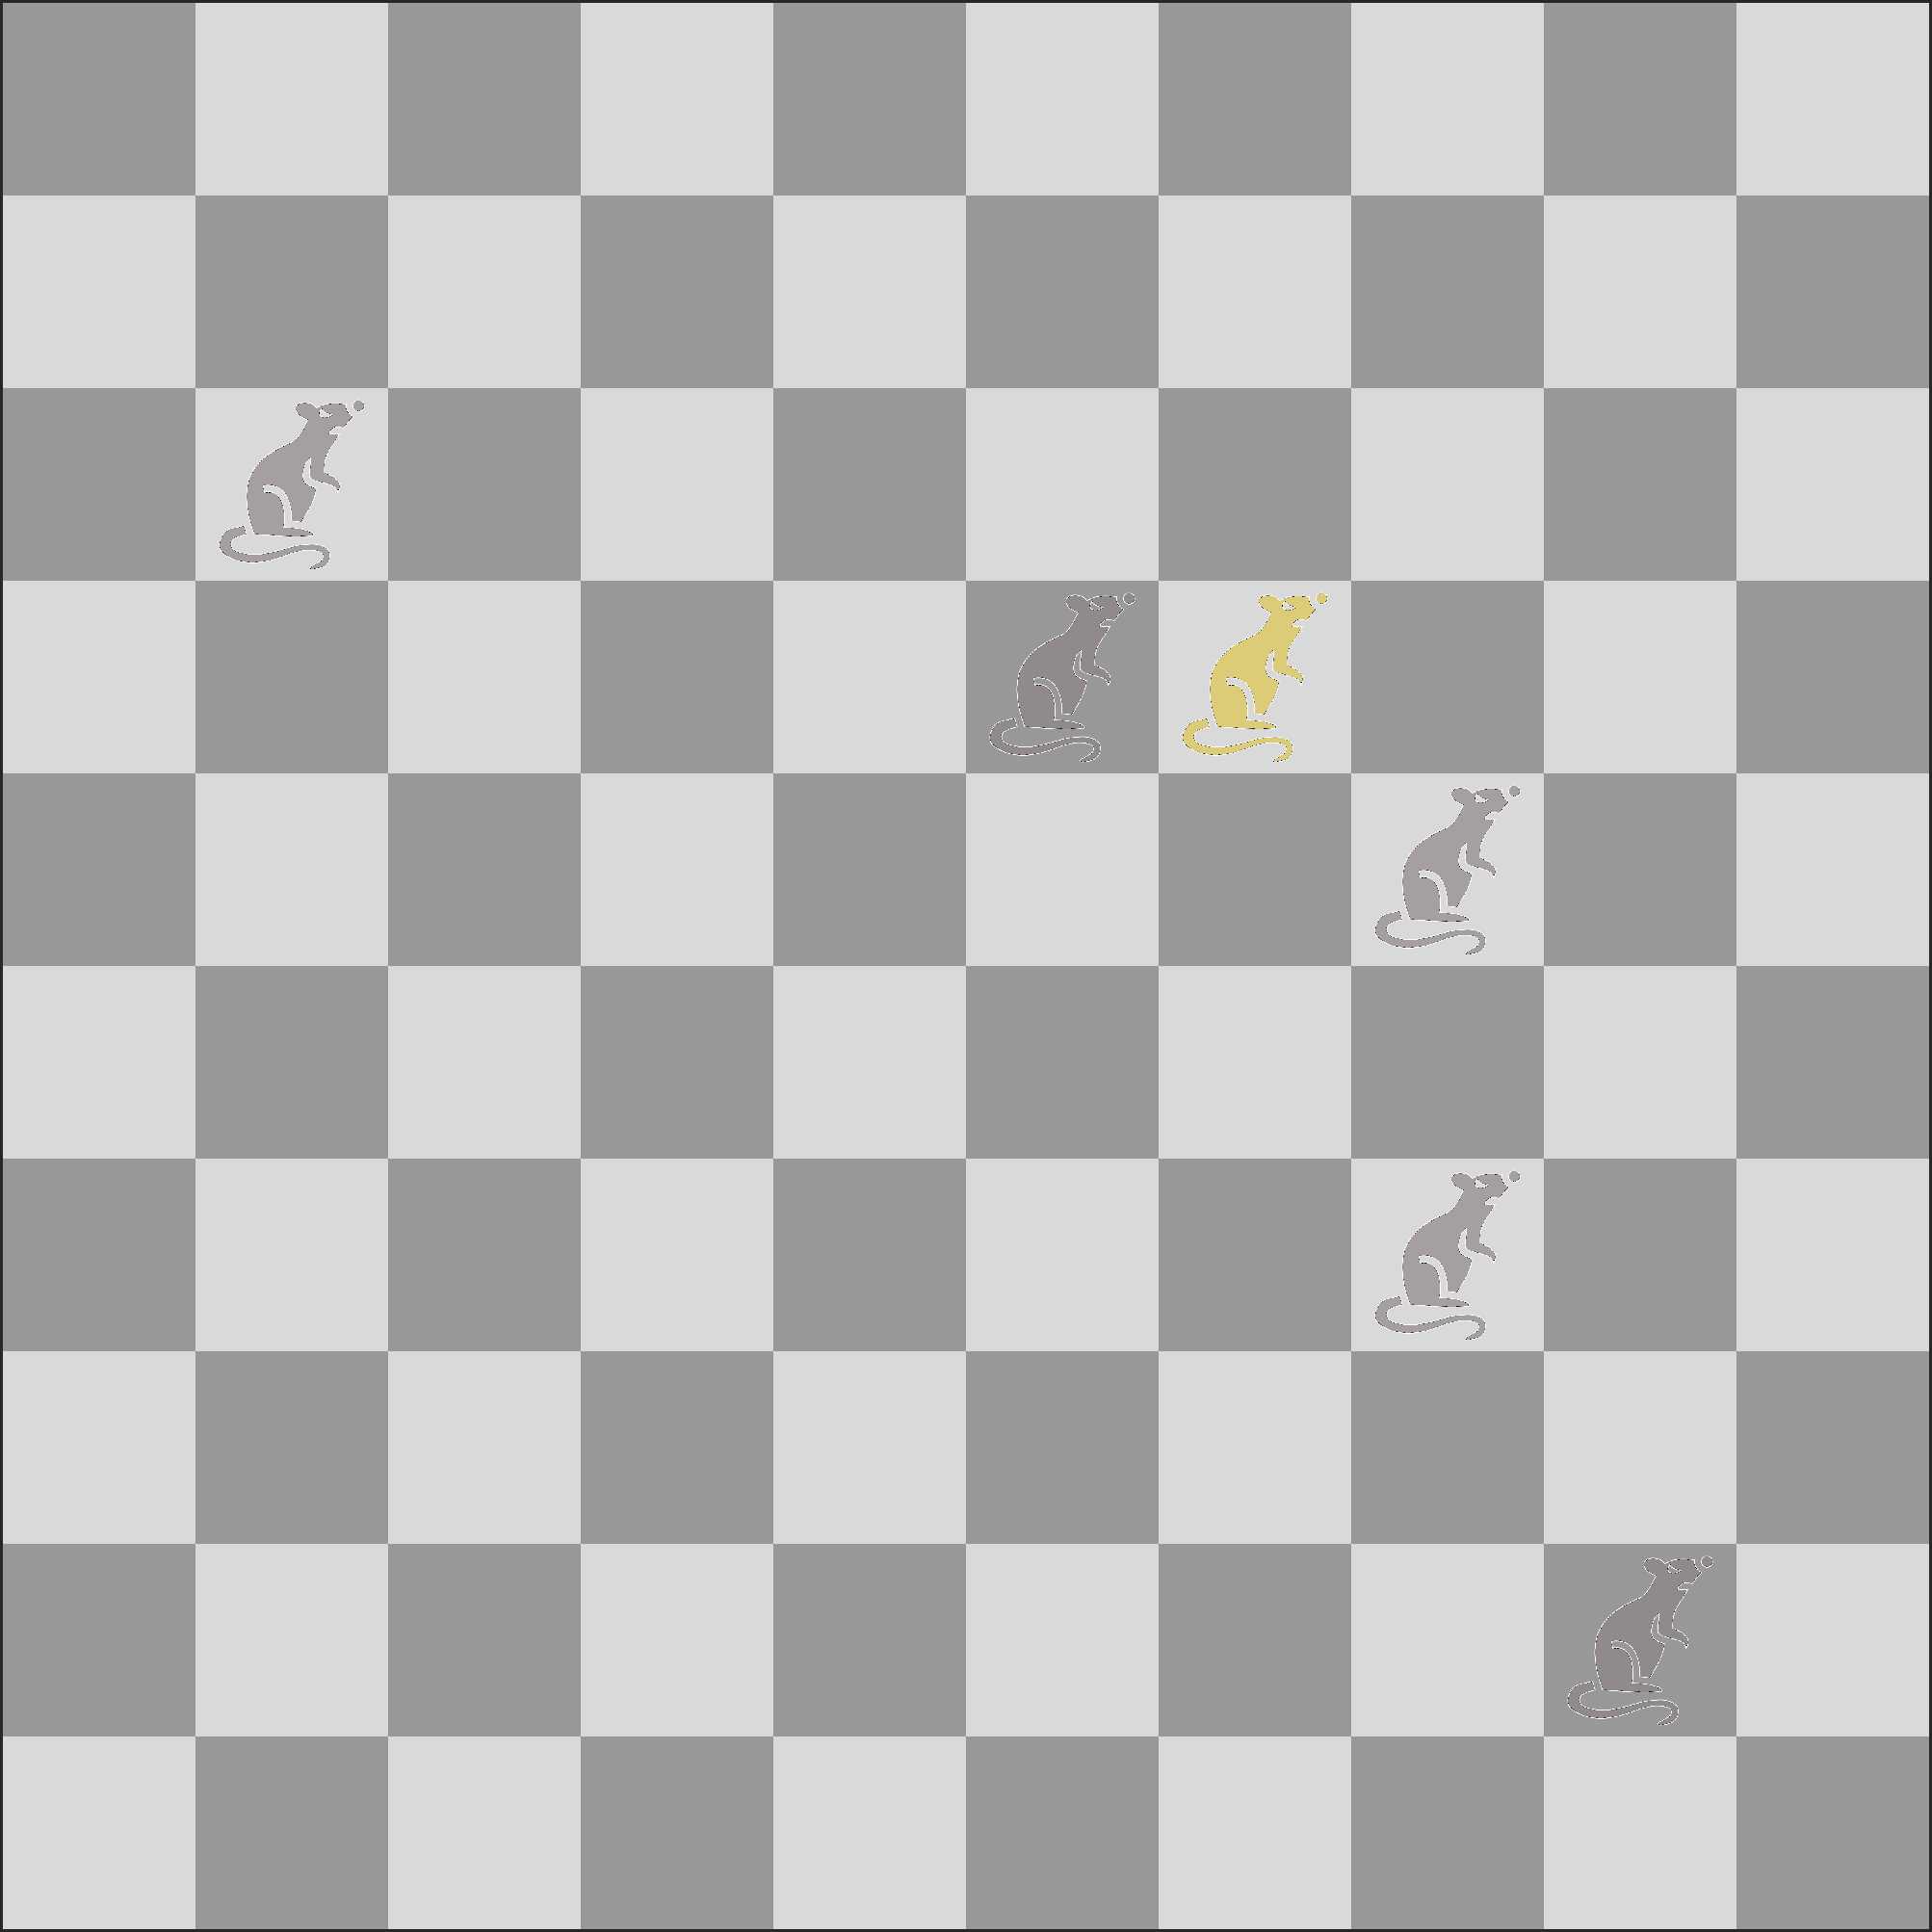

In [5]:
import time
from IPython.display import display, clear_output
from xander.engine import dice
from xander.engine.combat import Combat
from xander.engine.combat.arena import Simple
from xander.engine.actors import Stats


dice.random_seed()
combat = Combat(Simple(50, 50))

run_test = [
    (RandomAgent, (20, 40, 0)), (RandomAgent, (45, 5, 0)), (RandomAgent, (10, 20, 0)),
    (RandomAgent, (20, 30, 0)), (RandomAgent, (15, 5, 0)), (RandomAgent, (30, 20, 0)),
    # (RandomAgent, (5, 10, 0)), (RandomAgent, (5, 15, 0)), (RandomAgent, (40, 5, 0)),
]

the_rats = [
    agent(combat.join(Stats.from_json("../rat.json"), f"RA{i+1}", pos))
        for i, (agent, pos) in enumerate(run_test)
]

for rat in the_rats:
    combat.set_combatant_hook(rat.combatant, hook=rat.hook)

l: "Legality[typing.Any] | None" = None

i = 0

while sum(1 for rat in the_rats if rat.combatant.stats.dead) < (len(the_rats) - 1):
    # display(l)
    # display(combat)
    # display(combat.arena)

    combat.arena.save_image(f"demo-imgs/frame-{i:05}.png")

    # time.sleep(0.5)
    l = combat.step()

    i += 1
    # clear_output()
    
clear_output()
display(l)
display(combat)
display(combat.arena)


In [6]:
combat.arena.save_image(f"frame-{i:03}.png")